In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.integrate
from config import Config, load_config

In [2]:
def diff_eq(t, y, config: Config):
    theta_1, omega_1, theta_2, omega_2 = y
    pi = np.pi
    g = config.g
    l_1, l_2, l_b = config.l_1, config.l_2, config.l_b
    m_j, m_p, m_b, m_d = config.m_j, config.m_p, config.m_b, config.m_d
    rho_1, rho_2, rho_air = config.rho_1, config.rho_2, config.rho_air
    r_1, r_2, r_j, r_p, r_b, r_a, r_d = (
        config.r_1,
        config.r_2,
        config.r_j,
        config.r_p,
        config.r_b,
        config.r_a,
        config.r_d,
    )
    Cd_cyl, Cd_sph, Cd_disk = config.Cd_cyl, config.Cd_sph, config.Cd_disk
    I_extra = config.I_extra

    # fmt: off
    c11 = I_extra + l_1**3*rho_1/3 + l_1**2*l_2*rho_2 + l_1**2*m_j + l_1**2*m_p + l_b**3*rho_1/3 + l_b**2*m_b + m_d*r_a**2
    c12 = l_1*l_2**2*rho_2*np.cos(theta_1 - theta_2)/2 + l_1*l_2*m_p*np.cos(theta_1 - theta_2)
    c21 = l_1*l_2**2*rho_2*np.cos(theta_1 - theta_2)/2 + l_1*l_2*m_p*np.cos(theta_1 - theta_2)
    c22 = l_2**3*rho_2/3 + l_2**2*m_p
    det = (l_2**3*rho_2/3 + l_2**2*m_p)*(I_extra + l_1**3*rho_1/3 + l_1**2*l_2*rho_2 + l_1**2*m_j + l_1**2*m_p + l_b**3*rho_1/3 + l_b**2*m_b + m_d*r_a**2) - (l_1*l_2**2*rho_2*np.cos(theta_1 - theta_2)/2 + l_1*l_2*m_p*np.cos(theta_1 - theta_2))**2
    eqn_1_rhs = -g*l_1**2*rho_1*np.cos(theta_1)/2 - g*l_1*l_2*rho_2*np.cos(theta_1) - g*l_1*m_j*np.cos(theta_1) - g*l_1*m_p*np.cos(theta_1) + g*l_b**2*rho_1*np.cos(theta_1)/2 + g*l_b*m_b*np.cos(theta_1) - g*m_d*r_a - l_1*l_2**2*rho_2*np.sin(theta_1 - theta_2)*omega_2**2/2 - l_1*l_2*m_p*np.sin(theta_1 - theta_2)*omega_2**2
    eqn_2_rhs = -g*l_2**2*rho_2*np.cos(theta_2)/2 - g*l_2*m_p*np.cos(theta_2) + l_1*l_2**2*rho_2*np.sin(theta_1 - theta_2)*omega_1**2/2 + l_1*l_2*m_p*np.sin(theta_1 - theta_2)*omega_1**2
    eqn_1_rhs -= rho_air*(Cd_cyl*l_1**3*r_1*np.sqrt(l_1**2*omega_1**2)*omega_1 + 2*pi*Cd_disk*r_a**2*r_d**2*np.sqrt(r_a**2*omega_1**2)*omega_1 + 2*pi*Cd_sph*l_1**2*r_j**2*np.sqrt(l_1**2*omega_1**2)*omega_1 + 2*pi*Cd_sph*l_1*r_p**2*(l_1*omega_1 + l_2*np.cos(theta_1 - theta_2)*omega_2)*np.sqrt(l_1**2*omega_1**2 + 2*l_1*l_2*np.cos(theta_1 - theta_2)*omega_1*omega_2 + l_2**2*omega_2**2) + 2*pi*Cd_sph*l_b**2*r_b**2*np.sqrt(l_b**2*omega_1**2)*omega_1)/4
    eqn_2_rhs -= pi*Cd_sph*l_2*r_p**2*rho_air*(l_1*np.cos(theta_1 - theta_2)*omega_1 + l_2*omega_2)*np.sqrt(l_1**2*omega_1**2 + 2*l_1*l_2*np.cos(theta_1 - theta_2)*omega_1*omega_2 + l_2**2*omega_2**2)/2
    Q_1_drag_2_integrand = lambda s: Cd_cyl*l_1*r_2*rho_air*(l_1*omega_1 + s*np.cos(theta_1 - theta_2)*omega_2)*np.sqrt(l_1**2*omega_1**2 + 2*l_1*s*np.cos(theta_1 - theta_2)*omega_1*omega_2 + s**2*omega_2**2)
    Q_2_drag_2_integrand = lambda s: Cd_cyl*r_2*rho_air*s*(l_1*np.cos(theta_1 - theta_2)*omega_1 + s*omega_2)*np.sqrt(l_1**2*omega_1**2 + 2*l_1*s*np.cos(theta_1 - theta_2)*omega_1*omega_2 + s**2*omega_2**2)
    Q_1_drag_2 = scipy.integrate.quad(Q_1_drag_2_integrand, 0, l_2)[0]
    Q_2_drag_2 = scipy.integrate.quad(Q_2_drag_2_integrand, 0, l_2)[0]
    eqn_1_rhs -= Q_1_drag_2
    eqn_2_rhs -= Q_2_drag_2
    alpha_1 = (c22 * eqn_1_rhs - c12 * eqn_2_rhs) / det
    alpha_2 = (-c21 * eqn_1_rhs + c11 * eqn_2_rhs) / det
    # fmt: on

    return [omega_1, alpha_1, omega_2, alpha_2]


def solve_diff_eq(config: Config, init, t_start, t_end, dt):
    t_eval = np.arange(t_start, t_end, dt)
    sol = scipy.integrate.solve_ivp(
        diff_eq,
        (t_start, t_end),
        y0=init,
        t_eval=t_eval,
        args=(config,),
        method="RK45",
        # method='DOP853',
        # rtol=1e-5, atol=1e-8 # Adjust tolerances if needed
    )

    t = sol.t
    theta_1 = sol.y[0]
    omega_1 = sol.y[1]
    theta_2 = sol.y[2]
    omega_2 = sol.y[3]

    # Calculate positions
    x_1 = config.l_1 * np.cos(theta_1)
    y_1 = config.l_1 * np.sin(theta_1)
    x_2 = x_1 + config.l_2 * np.cos(theta_2)
    y_2 = y_1 + config.l_2 * np.sin(theta_2)
    x_b = -config.l_b * np.cos(theta_1)
    y_b = -config.l_b * np.sin(theta_1)

    # Calculate velocities
    v_x_1 = -config.l_1 * np.sin(theta_1) * omega_1
    v_y_1 = config.l_1 * np.cos(theta_1) * omega_1
    v_x_2 = v_x_1 - config.l_2 * np.sin(theta_2) * omega_2
    v_y_2 = v_y_1 + config.l_2 * np.cos(theta_2) * omega_2
    v_1 = np.sqrt(v_x_1**2 + v_y_1**2)
    v_2 = np.sqrt(v_x_2**2 + v_y_2**2)

    return {
        "t": t,
        "dt": dt,
        "theta_1": theta_1,
        "omega_1": omega_1,
        "theta_2": theta_2,
        "omega_2": omega_2,
        "x_1": x_1,
        "y_1": y_1,
        "x_2": x_2,
        "y_2": y_2,
        "x_b": x_b,
        "y_b": y_b,
        "v_x_1": v_x_1,
        "v_y_1": v_y_1,
        "v_1": v_1,
        "v_x_2": v_x_2,
        "v_y_2": v_y_2,
        "v_2": v_2,
    }

In [3]:
def get_max_velocity_index(solution):
    # Get angle of (x_2, y_2) relative to origin
    x_2, y_2 = solution["x_2"], solution["y_2"]
    angles = np.arctan2(y_2, x_2)  # from -pi to pi
    first_negative = np.argwhere(angles < 0)
    first_negative = first_negative[0].item() if len(first_negative) > 0 else 0
    next_positive = first_negative + np.argwhere(angles[first_negative:] > 0)
    next_positive = (
        next_positive[0].item() if len(next_positive) > 0 else len(angles) - 1
    )
    next_negative = next_positive + np.argwhere(angles[next_positive:] < 0)
    next_negative = (
        next_negative[0].item() if len(next_negative) > 0 else len(angles) - 1
    )
    # print(f"First negative at index {first_negative} time {t[first_negative]}")
    # print(f"Next positive at index {next_positive} time {t[next_positive]}")
    # print(f"Next negative at index {next_negative} time {t[next_negative]}")

    # Get peak velocity within the valid range
    max_v_2_index = (
        np.argmax(solution["v_2"][next_positive:next_negative]) + next_positive
    )
    return max_v_2_index


def analyze_solution(solution, config):
    t = solution["t"]
    v_2, v_x_2, v_y_2 = solution["v_2"], solution["v_x_2"], solution["v_y_2"]
    max_v_2_index = get_max_velocity_index(solution)
    max_v_angle = np.arctan2(v_y_2[max_v_2_index], v_x_2[max_v_2_index])
    print(f"Max velocity {v_2[max_v_2_index]:.1f} m/s at time {t[max_v_2_index]:.3f}")
    print(
        f"Angle at max velocity {max_v_angle:.3f} radians {max_v_angle * 180 / np.pi:.1f} degrees"
    )

    om1 = solution["omega_1"][max_v_2_index]
    om2 = solution["omega_2"][max_v_2_index]
    print(f"Max velocity omega_1 {om1:.2f} omega_2 {om2:.2f} (ratio {om2 / om1:.2f})")
    om1 = solution["omega_1"][0]
    om2 = solution["omega_2"][0]
    print(f"Initial omega_1 {om1:.2f} omega_2 {om2:.2f}")

    # Kinetic energy at max velocity
    max_v = v_2[max_v_2_index]
    ke = 0.5 * max_v**2 * config.m_p
    print(f"Max kinetic energy {ke:.1f} J")

In [4]:
def plot_trajectory(solution, config):
    x_1, y_1 = solution["x_1"], solution["y_1"]
    x_2, y_2 = solution["x_2"], solution["y_2"]
    x_b, y_b = solution["x_b"], solution["y_b"]

    # Get peak velocity
    v_x_2, v_y_2 = solution["v_x_2"], solution["v_y_2"]
    max_v_2_index = get_max_velocity_index(solution)

    plt.figure(figsize=(8, 8))

    # Plot the initial state
    init_alpha = 0.25
    plt.plot(
        [0, x_1[0]],
        [0, y_1[0]],
        "o-",
        lw=2,
        color="blue",
        solid_capstyle="round",
        alpha=init_alpha,
    )
    plt.plot(
        [x_1[0], x_2[0]],
        [y_1[0], y_2[0]],
        "-",
        lw=2,
        color="blue",
        solid_capstyle="round",
        alpha=init_alpha,
    )
    plt.plot(
        [0, x_b[0]],
        [0, y_b[0]],
        "-",
        lw=2,
        color="blue",
        solid_capstyle="round",
        alpha=init_alpha,
    )
    plt.plot([0], [0], "o", markersize=10, color="black", alpha=init_alpha)
    plt.plot([x_b[0]], [y_b[0]], "o", markersize=10, color="green", alpha=init_alpha)
    plt.plot([x_2[0]], [y_2[0]], "o", markersize=10, color="red", alpha=init_alpha)

    # Plot the state at max velocity
    plt.plot(
        [0, x_1[max_v_2_index]],
        [0, y_1[max_v_2_index]],
        "o-",
        lw=2,
        color="blue",
        solid_capstyle="round",
    )
    plt.plot(
        [x_1[max_v_2_index], x_2[max_v_2_index]],
        [y_1[max_v_2_index], y_2[max_v_2_index]],
        "-",
        lw=2,
        color="blue",
        solid_capstyle="round",
    )
    plt.plot(
        [0, x_b[max_v_2_index]],
        [0, y_b[max_v_2_index]],
        "-",
        lw=2,
        color="blue",
        solid_capstyle="round",
    )
    plt.plot(
        [x_b[max_v_2_index]], [y_b[max_v_2_index]], "o", markersize=10, color="green"
    )
    plt.plot(
        [x_2[max_v_2_index]], [y_2[max_v_2_index]], "o", markersize=10, color="red"
    )

    # Plot the trajectory
    plt.plot(x_2, y_2, ".-", lw=1, markersize=1, color="gray")

    # Plot the velocity vector
    plt.quiver(
        x_2[max_v_2_index],
        y_2[max_v_2_index],
        v_x_2[max_v_2_index],
        v_y_2[max_v_2_index],
        angles="xy",
        color="red",
    )

    max_size = (config.l_1 + config.l_2) * 1.1
    plt.xlim(-max_size, max_size)
    plt.ylim(-max_size, max_size)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.grid()
    plt.show()


def plot_position_velocity(solution, config):
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(solution["t"], solution["theta_1"], label="Theta 1 (rad)")
    plt.plot(solution["t"], solution["theta_2"], label="Theta 2 (rad)")
    plt.title("Angles vs Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (rad)")
    plt.legend()
    plt.grid(True)

    # Plot velocities
    plt.subplot(2, 1, 2)
    plt.plot(solution["t"], solution["v_1"], label="Velocity 1 (m/s)")
    plt.plot(solution["t"], solution["v_2"], label="Velocity 2 (m/s)")
    plt.title("Velocities vs Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Max velocity 133.7 m/s at time 0.051
Angle at max velocity 0.653 radians 37.4 degrees
Max velocity omega_1 -41.29 omega_2 -180.02 (ratio 4.36)
Initial omega_1 -75.40 omega_2 -75.40
Max kinetic energy 107.3 J


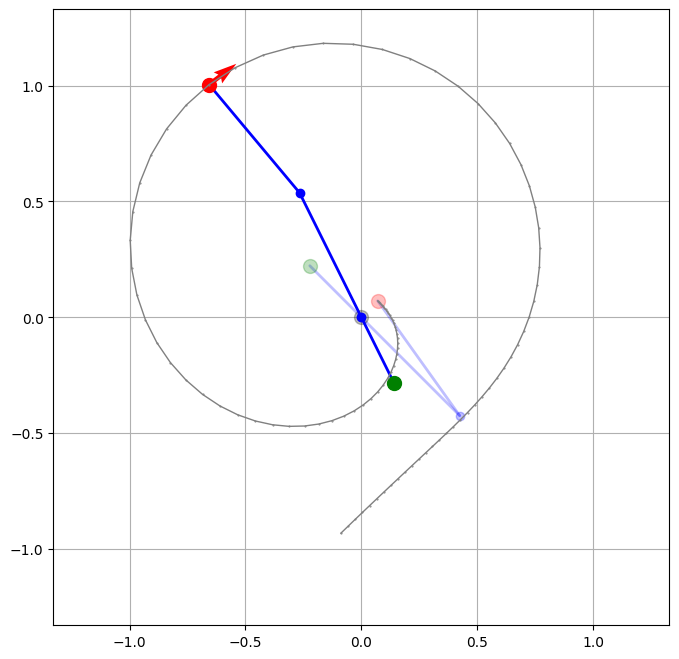

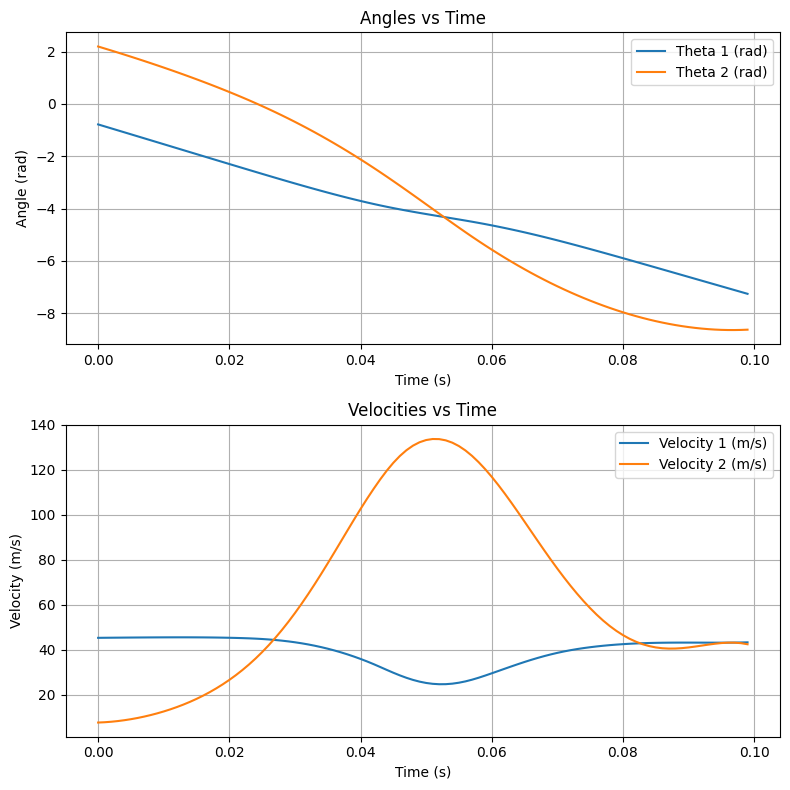

In [5]:
# Design parameters
config_file = "design_1.yaml"
config = load_config(config_file)

# Initial conditions
theta_1_init = -0.25 * np.pi
omega_1_init = -12 * 2 * np.pi
theta_2_init = theta_1_init + config.theta_2_init_offset
omega_2_init = omega_1_init
init = [theta_1_init, omega_1_init, theta_2_init, omega_2_init]

solution = solve_diff_eq(config, init, t_start=0, t_end=0.1, dt=0.001)

analyze_solution(solution, config)
plot_trajectory(solution, config)
plot_position_velocity(solution, config)

In [ ]:
def plot_animation(solution, config, slow_motion=1):
    x_1, y_1 = solution["x_1"], solution["y_1"]
    x_2, y_2 = solution["x_2"], solution["y_2"]
    x_b, y_b = solution["x_b"], solution["y_b"]

    # Create animation
    fig = plt.figure(figsize=(8, 8))
    max_size = (config.l_1 + config.l_2) * 1.1
    ax = fig.add_subplot(
        111, autoscale_on=False, xlim=(-max_size, max_size), ylim=(-max_size, max_size)
    )
    ax.set_aspect("equal")
    ax.grid()

    (rod_1,) = ax.plot([], [], "o-", lw=2, color="blue", solid_capstyle="round")
    (rod_2,) = ax.plot([], [], "-", lw=2, color="blue", solid_capstyle="round")
    (rod_b,) = ax.plot([], [], "-", lw=2, color="blue", solid_capstyle="round")
    (joint_mass,) = ax.plot([], [], "o", markersize=10, color="blue")
    (balance_mass,) = ax.plot([], [], "o", markersize=10, color="green")
    (tip_mass,) = ax.plot([], [], "o", markersize=10, color="red")
    time_template = "Time = %.1fs"
    time_text = ax.text(0.05, 0.9, "", transform=ax.transAxes)
    (trace_line,) = ax.plot([], [], ".-", lw=1, markersize=1, color="gray", alpha=0.5)

    def init():
        rod_1.set_data([], [])
        rod_2.set_data([], [])
        rod_b.set_data([], [])
        joint_mass.set_data([], [])
        balance_mass.set_data([], [])
        tip_mass.set_data([], [])
        trace_line.set_data([], [])
        time_text.set_text("")
        return rod_1, rod_2, joint_mass, tip_mass, trace_line, time_text

    def animate(i):
        # Plot rods
        rod_1.set_data([0, x_1[i]], [0, y_1[i]])
        rod_2.set_data([x_1[i], x_2[i]], [y_1[i], y_2[i]])
        rod_b.set_data([0, x_b[i]], [0, y_b[i]])
        # Plot masses
        joint_mass.set_data([x_1[i]], [y_1[i]])
        balance_mass.set_data([x_b[i]], [y_b[i]])
        tip_mass.set_data([x_2[i]], [y_2[i]])
        # Update trace
        # start_idx = max(0, i - max_trace)
        start_idx = 0
        trace_line.set_data(x_2[start_idx : i + 1], y_2[start_idx : i + 1])
        time_text.set_text(time_template % solution["t"][i])
        return rod_1, rod_2, joint_mass, tip_mass, trace_line, time_text

    ani = animation.FuncAnimation(
        fig,
        animate,
        frames=len(solution["t"]),
        interval=slow_motion
        * max(1, int(solution["dt"] * 1000)),  # Ensure interval > 0
        blit=True,
        init_func=init,
    )

    plt.close()
    return ani


plt.rc("animation", html="html5")
plot_animation(solution, config, slow_motion=20)